# Quantum state tomography (QST) with Gradient descent (GD) for experimental data

This notebook is a demonstration of using the different GD methods to do QST for real exp data. For that demonstration we will show the case of 2 qubits unknown states.

## Note 1:

For the GD methods it is necesary the library Jax (https://github.com/google/jax). Also QuTip is a very important library.

In [3]:
# To call the libraries for the GD-QST
import sys
sys.path.insert(0, '..')
# You have to change the path of the library 
import os
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=true:intra_op_parallelism_threads=8"  # set 8 to your number of cores

from qutip import * 
from itertools import *
import numpy as np
import matplotlib.pyplot as plt 
import qutip as qtp
#from qutip import basis, tensor

# Libraries for the different methods of doing QST with GD
from qst_tec.gdchol_triangular import gd_chol_triangular, cholesky_f, rho_cons
from qst_tec.gdchol_rank import gd_chol_rank
from qst_tec.gdmanifold import gd_manifold, mix_rho, Nkets, softmax, expect_prob_ket
from qst_tec.gdmanifold_adaptive import gd_manifold_adaptive, mix_rho, Nkets, softmax, expect_prob_ket
from qst_tec.gdproj import gd_project
from qst_tec.least_square import least_square_qst
from qst_tec.compressed_sensing import compressed_sensing_qst

import jax
import jax.numpy as jnp
import jax.numpy.linalg  as nlg
from jax import grad
from jax import jit
from jax.example_libraries import optimizers
from jax import config
config.update("jax_enable_x64", True) # We want float64 for better precision
import optax

import tqdm   # For the progressbars
import time

### First we will define the number of qubits and the measurement operators. We will use the Pauli matrices.

In [56]:
number_qubits: int = 2
dimension: int = 2**number_qubits
HS: int = dimension

# Define eigenstates for a single qubit
h = basis(2, 0)  # eigenvector of σ_z with eigenvalue +1
v = basis(2, 1)  # eigenvector of σ_z with eigenvalue -1
p = (basis(2, 0) + basis(2, 1)) / np.sqrt(2)  # eigenvector of σ_x with eigenvalue +1
r = (basis(2, 0) + 1j * basis(2, 1)) / np.sqrt(2)  # eigenvector of σ_y with eigenvalue +1

# Define the desired combinations explicitly
projections = [
    (h, h), (h, v), (h, r), (h, p),
    (v, p), (v, r), (v, h), (v, v),
    (r, v), (r, h), (r, r), (r, p),
    (p, p), (p, r), (p, h), (p, v)
]

# Generate 16 measurement operators as tensor products of projectors
Measu_ope = []
for s in projections:
    # Compute the projection operator for each single qubit
    proj1 = s[0] * s[0].dag()
    proj2 = s[1] * s[1].dag()
    # Get the tensor product to form the two-qubit projector
    combined_proj = tensor(proj1, proj2)
    # Wrap into Qobj with dims consistent with a 2**number_qubits system
    op = Qobj(combined_proj.full(), dims=([[2**number_qubits], [2**number_qubits]]))
    Measu_ope.append(op)

print(Measu_ope[1:3])


#-----------------------------------------------------------------------
# It is necesary to transform the measurement operators from a numpy 
# type to a jax type (jax.np), that because of the jax grad 

ops_np = [op.full() for op in Measu_ope] # transforming from qutip object to numpy
ops_jnp = jnp.asarray(ops_np) # transforming from numpy to jax.np

[Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]], Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5+0.j  0. -0.5j 0. +0.j  0. +0.j ]
 [0. +0.5j 0.5+0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]]


## The ansatz

For each one of the GD methods the creation of the ansatz is different, for the specific shape and structure of the ansatz go to the paper or check the other notebooks that shows the ansatz of each case.  

In [14]:

def ansatz(kn: int):
    """
    Creates the proper ansatz structure for the different GD methods
    
    Args: 
        kn (int) : rank number
    
    Output:
        T_rank : Ansatz GD-Cholesky rank
        T_triangular : Ansatz GD-Cholesky triangular
        column_ket_pro : Ansatz GD-manifold
        ket_f, prob1_array_jnp : Ansatz GD-projective 
        
    """
    
    # T_rank  = arbitrary r x p matrix ansatz for Cholesky
    real_part = np.random.rand(kn, dimension)  # Random numbers from a uniform distribution over [0, 1)
    imaginary_part = np.random.rand(kn, dimension)  # Same for the imaginary part
    guess = real_part + 1j * imaginary_part
    T_rank = jnp.asarray(guess)

    # T_triangular Lower traingular matrix ansatz for Cholesky
    T_triangular = jnp.asarray(rho_cons(np.random.rand(dimension, dimension) + 1j*np.random.rand(dimension, dimension)))

    ketl1 = Nkets(kn, HS)   # generate kn random kets with hilbert space HS
    ketl1_np = [a.full() for a in ketl1]
    ketl2 = [a.full().flatten() for a in ketl1]
    ketl2_np = np.asarray(ketl2)
    ketl2_jnp = jnp.asarray(ketl2)
    ketl1_jnp = jnp.asarray(ketl1_np)
    prob1_array = np.random.rand(kn) # create the second list for the random probabilities
    prob1_array = softmax(prob1_array)
    prob1_array_jnp = jnp.asarray(prob1_array)
    mixed_density = 0
    for i in range(len(ketl1)): # to create the density matrix
        density_i = ketl1[i]*ketl1[i].dag()
        mixed_density += prob1_array[i]*density_i
    
    rho_ran = mixed_density
    rho_ran_np = rho_ran.full()

    # --- kets for GD proj -------------------------------------
    ket_f = ketl1_jnp.flatten()
    ket_f = ket_f[:, jnp.newaxis]

    # --- column ket for GD manifold ------------------------
    prob_sqrt = jnp.sqrt(prob1_array_jnp) 
    prob1_array_reshaped = prob_sqrt[:, jnp.newaxis]
    ket_prob_o = prob1_array_reshaped * ketl2_jnp 
    ket_prob = ket_prob_o.flatten()
    column_ket_pro = ket_prob[:, np.newaxis]

    return T_rank, T_triangular, column_ket_pro, ket_f, prob1_array_jnp

## Implementing GD

For the case of a random density matrix for 3 qubits as the original density matrix (the one we want to reconstruct) created with QuTip $\rho_{random}$

In [76]:
# List to save the values of fidelity and time for the GD methods

fid_list_chol_rank, fid_list_chol_triangular, fid_list_mani, fid_list_mani_adaptive, fid_list_proj = [], [], [], [], []
time_list_chol_rank, time_list_chol_triangular, time_list_mani, time_list_mani_adaptive, time_list_proj = [], [], [], [], []


max_itera: int = 300
batch_s = round(0.5*len(ops_jnp)) # The batch size, taking a group of measurement operators 

# The for is to run all the methods multiple times, and then have an average 
for i in range(6):

    # creating the original densirty matrix, this with a random rho from QuTip
    #rho_or = rand_dm(2**number_qubits)
    rho_or = Qobj(np.array([
    [0.00128192 + 0.j,         0.0157286 - 0.000213806j,   -0.00861746 - 0.00190583j,  -0.000305016 - 0.000598004j],
    [0.0157286 + 0.000213806j,  0.754172 + 0.j,            -0.425923  - 0.0328755j,    -0.00548998 + 0.00440955j],
    [-0.00861746 + 0.00190583j, -0.425923 + 0.0328755j,      0.24394 + 0.j,           0.00382522 - 0.00319838j],
    [-0.000305016 + 0.000598004j, -0.00548998 - 0.00440955j, 0.00382522 + 0.00319838j,   0.000605652 + 0.j]
    ]), dims=[[4], [4]])

    # Skip the header row so that only data rows are read
    data = np.loadtxt("data.txt", usecols=[i+1], dtype=str, skiprows=3)[-16:].astype(np.int64)

    # Sum elements at indices 0, 1, 4, and 5 to calculate the divisor
    divisor = data[[0, 1, 4, 5]].sum()

    # Divide all elements by the divisor
    data = data / divisor

    #data from theory
    #data=qtp.expect(rho_or, Measu_ope)

    ##-----------------GD-QST starts ---------------
    # define rank of ansatz
    rank = 2**number_qubits # maximum rank is 2**N
    T_rank, T_triangular, column_ket_pro, ket_f, prob1_array_jnp = ansatz(rank)

    # ..........................................................................
    # GD-QST-Cholesky-Rank 
    
    rho_gd_chol_rank, f_gd_chol_rank, t_gd_chol_rank, _ = gd_chol_rank(data, rho_or, ops_jnp, T_rank, max_itera, batch_s, 
                                                            lr=0.5, decay= 0.999,lamb=0, tqdm_off=False)
    fid_list_chol_rank.append(f_gd_chol_rank)
    time_list_chol_rank.append(t_gd_chol_rank)

    #...........................................................................
    # GD-QST-Cholesky-triangular
    rho_gd_chol_triangular, f_gd_chol_triangular, t_gd_chol_triangular, _ = gd_chol_triangular(data, rho_or, ops_jnp, T_triangular, max_itera, batch_s, 
                                                            lr=0.5, decay= 0.999,lamb=0, tqdm_off=False)
    fid_list_chol_triangular.append(f_gd_chol_triangular)
    time_list_chol_triangular.append(t_gd_chol_triangular)

    # ...........................................................................
    # GD-QST-manifold
    rho_gd_mani, f_gd_mani, t_gd_mani, loss_gd_mani = gd_manifold(data, rho_or, ops_jnp, column_ket_pro, max_itera, batch_s, 
                                                           lr=0.1, decay=0.997, lamb=0, tqdm_off=False)   
    fid_list_mani.append(f_gd_mani)
    time_list_mani.append(t_gd_mani)
             
    # ...........................................................................                                  
    # GD-QST-manifold-adaptive
    rho_gd_mani_adaptive, f_gd_mani_adaptive, t_gd_mani_adaptive, _ = gd_manifold_adaptive(data, rho_or, ops_jnp, column_ket_pro, max_itera, batch_s, 
                                                            lr=1e-1, boost = 1.08, decay = 0.99, lamb = 0, tqdm_off=False)
    fid_list_mani_adaptive.append(f_gd_mani_adaptive)
    time_list_mani_adaptive.append(t_gd_mani_adaptive)
    
    # ...........................................................................
    # GD-QST-projection
    rho_gd_proj, f_gd_proj, t_gd_proj, loss_gd_proj = gd_project(data, rho_or, ops_jnp, ket_f, prob1_array_jnp, max_itera, batch_s,
                                                             lr=1e-1, decay=0.099, lamb=0, tqdm_off=False)
    fid_list_proj.append(f_gd_proj)
    time_list_proj.append(t_gd_proj)

[5.91858655e-04 7.59157369e-01 3.68859466e-01 3.60113111e-01
 1.23194283e-01 1.17056490e-01 2.44656832e-01 6.35700037e-04
 3.78197681e-01 1.21900962e-01 3.70240470e-02 2.52307153e-01
 3.52923124e-02 2.42157873e-01 1.26876959e-01 3.92906464e-01]
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.28192e-03+0.j          1.57286e-02-0.00021381j
  -8.61746e-03-0.00190583j -3.05016e-04-0.000598j  ]
 [ 1.57286e-02+0.00021381j  7.54172e-01+0.j
  -4.25923e-01-0.0328755j  -5.48998e-03+0.00440955j]
 [-8.61746e-03+0.00190583j -4.25923e-01+0.0328755j
   2.43940e-01+0.j          3.82522e-03-0.00319838j]
 [-3.05016e-04+0.000598j   -5.48998e-03-0.00440955j
   3.82522e-03+0.00319838j  6.05652e-04+0.j        ]]
[1.28192000e-03 7.54172000e-01 3.77940766e-01 3.93455560e-01
 1.26098046e-01 1.25471206e-01 2.43940000e-01 6.05652000e-04
 3.72979276e-01 1.24516790e-01 3.76451340e-02 2.75261695e-01
 3.96090750e-02 2.28513518e-01 1.13993500e-01 3.71898846e-01]


Fidelity GD-projection 0.9932: 100%|██████████| 300/300 [00:01<00:00, 295.33it/s]


[7.65593335e-04 7.58207611e-01 3.78743526e-01 3.67800045e-01
 1.20963747e-01 1.20063049e-01 2.43683855e-01 5.85453727e-04
 3.91803648e-01 1.25332132e-01 3.44967350e-02 2.52150417e-01
 3.82346318e-02 2.46115740e-01 1.26773249e-01 3.98423778e-01]
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.28192e-03+0.j          1.57286e-02-0.00021381j
  -8.61746e-03-0.00190583j -3.05016e-04-0.000598j  ]
 [ 1.57286e-02+0.00021381j  7.54172e-01+0.j
  -4.25923e-01-0.0328755j  -5.48998e-03+0.00440955j]
 [-8.61746e-03+0.00190583j -4.25923e-01+0.0328755j
   2.43940e-01+0.j          3.82522e-03-0.00319838j]
 [-3.05016e-04+0.000598j   -5.48998e-03-0.00440955j
   3.82522e-03+0.00319838j  6.05652e-04+0.j        ]]
[1.28192000e-03 7.54172000e-01 3.77940766e-01 3.93455560e-01
 1.26098046e-01 1.25471206e-01 2.43940000e-01 6.05652000e-04
 3.72979276e-01 1.24516790e-01 3.76451340e-02 2.75261695e-01
 3.96090750e-02 2.28513518e-01 1.13993500e-01 3.71898846e-01]


Fidelity GD-projection 0.9957: 100%|██████████| 300/300 [00:01<00:00, 298.73it/s]


[7.35930736e-04 7.54458874e-01 3.77705628e-01 3.71601732e-01
 1.25497835e-01 1.19307359e-01 2.49307359e-01 3.89610390e-04
 3.87532468e-01 1.20389610e-01 3.67099567e-02 2.39047619e-01
 3.42857143e-02 2.36277056e-01 1.20216450e-01 3.89134199e-01]
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.28192e-03+0.j          1.57286e-02-0.00021381j
  -8.61746e-03-0.00190583j -3.05016e-04-0.000598j  ]
 [ 1.57286e-02+0.00021381j  7.54172e-01+0.j
  -4.25923e-01-0.0328755j  -5.48998e-03+0.00440955j]
 [-8.61746e-03+0.00190583j -4.25923e-01+0.0328755j
   2.43940e-01+0.j          3.82522e-03-0.00319838j]
 [-3.05016e-04+0.000598j   -5.48998e-03-0.00440955j
   3.82522e-03+0.00319838j  6.05652e-04+0.j        ]]
[1.28192000e-03 7.54172000e-01 3.77940766e-01 3.93455560e-01
 1.26098046e-01 1.25471206e-01 2.43940000e-01 6.05652000e-04
 3.72979276e-01 1.24516790e-01 3.76451340e-02 2.75261695e-01
 3.96090750e-02 2.28513518e-01 1.13993500e-01 3.71898846e-01]


Fidelity GD-projection 0.9913: 100%|██████████| 300/300 [00:01<00:00, 255.80it/s]


[7.76364028e-04 7.63338365e-01 3.78175545e-01 3.75717058e-01
 1.24045719e-01 1.11839551e-01 2.44209618e-01 7.33232694e-04
 3.81281001e-01 1.20336424e-01 3.97239595e-02 2.49040328e-01
 3.62734527e-02 2.51671339e-01 1.25727841e-01 3.89260298e-01]
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.28192e-03+0.j          1.57286e-02-0.00021381j
  -8.61746e-03-0.00190583j -3.05016e-04-0.000598j  ]
 [ 1.57286e-02+0.00021381j  7.54172e-01+0.j
  -4.25923e-01-0.0328755j  -5.48998e-03+0.00440955j]
 [-8.61746e-03+0.00190583j -4.25923e-01+0.0328755j
   2.43940e-01+0.j          3.82522e-03-0.00319838j]
 [-3.05016e-04+0.000598j   -5.48998e-03-0.00440955j
   3.82522e-03+0.00319838j  6.05652e-04+0.j        ]]
[1.28192000e-03 7.54172000e-01 3.77940766e-01 3.93455560e-01
 1.26098046e-01 1.25471206e-01 2.43940000e-01 6.05652000e-04
 3.72979276e-01 1.24516790e-01 3.76451340e-02 2.75261695e-01
 3.96090750e-02 2.28513518e-01 1.13993500e-01 3.71898846e-01]


Fidelity GD-projection 0.9939: 100%|██████████| 300/300 [00:01<00:00, 293.85it/s]


[7.70646915e-04 7.53136105e-01 3.79586419e-01 3.63788158e-01
 1.25829516e-01 1.20263732e-01 2.51573404e-01 6.42205763e-04
 3.78130753e-01 1.25058869e-01 3.96026887e-02 2.12784176e-01
 3.74620028e-02 2.81243310e-01 1.29939633e-01 3.96754720e-01]
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.28192e-03+0.j          1.57286e-02-0.00021381j
  -8.61746e-03-0.00190583j -3.05016e-04-0.000598j  ]
 [ 1.57286e-02+0.00021381j  7.54172e-01+0.j
  -4.25923e-01-0.0328755j  -5.48998e-03+0.00440955j]
 [-8.61746e-03+0.00190583j -4.25923e-01+0.0328755j
   2.43940e-01+0.j          3.82522e-03-0.00319838j]
 [-3.05016e-04+0.000598j   -5.48998e-03-0.00440955j
   3.82522e-03+0.00319838j  6.05652e-04+0.j        ]]
[1.28192000e-03 7.54172000e-01 3.77940766e-01 3.93455560e-01
 1.26098046e-01 1.25471206e-01 2.43940000e-01 6.05652000e-04
 3.72979276e-01 1.24516790e-01 3.76451340e-02 2.75261695e-01
 3.96090750e-02 2.28513518e-01 1.13993500e-01 3.71898846e-01]


Fidelity GD-projection 0.9869: 100%|██████████| 300/300 [00:01<00:00, 296.65it/s]


[1.27754711e-03 7.50558927e-01 3.74896199e-01 3.95911849e-01
 1.30565315e-01 1.17598211e-01 2.40498243e-01 5.74896199e-04
 3.81539444e-01 1.18684126e-01 3.55796870e-02 2.40753753e-01
 3.86458001e-02 2.54231875e-01 1.14723730e-01 3.79878633e-01]
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.28192e-03+0.j          1.57286e-02-0.00021381j
  -8.61746e-03-0.00190583j -3.05016e-04-0.000598j  ]
 [ 1.57286e-02+0.00021381j  7.54172e-01+0.j
  -4.25923e-01-0.0328755j  -5.48998e-03+0.00440955j]
 [-8.61746e-03+0.00190583j -4.25923e-01+0.0328755j
   2.43940e-01+0.j          3.82522e-03-0.00319838j]
 [-3.05016e-04+0.000598j   -5.48998e-03-0.00440955j
   3.82522e-03+0.00319838j  6.05652e-04+0.j        ]]
[1.28192000e-03 7.54172000e-01 3.77940766e-01 3.93455560e-01
 1.26098046e-01 1.25471206e-01 2.43940000e-01 6.05652000e-04
 3.72979276e-01 1.24516790e-01 3.76451340e-02 2.75261695e-01
 3.96090750e-02 2.28513518e-01 1.13993500e-01 3.71898846e-01]


Fidelity GD-projection 0.9931: 100%|██████████| 300/300 [00:00<00:00, 303.88it/s]


 Calculation of the mean value of fidelity and standard deviation. Also for the case of the time of each method.

In [59]:
fid_list_chol_rank = np.array(fid_list_chol_rank)
fid_list_chol_triangular = np.array(fid_list_chol_triangular)
fid_list_mani = np.array(fid_list_mani)
fid_list_mani_adaptive = np.array(fid_list_mani_adaptive)
fid_list_proj = np.array(fid_list_proj)


# Compute mean fidelity
mean_fid_chol_rank = np.mean(fid_list_chol_rank, axis=0)
mean_fid_chol_triangular = np.mean(fid_list_chol_triangular, axis=0)
mean_fid_mani = np.mean(fid_list_mani, axis=0)
mean_fid_mani_adaptive = np.mean(fid_list_mani_adaptive, axis=0)
mean_fid_proj = np.mean(fid_list_proj, axis=0)

# Compute standard deviation in the mean fidelity
std_fid_chol_rank = np.std(fid_list_chol_rank, axis=0)
std_fid_chol_triangular = np.std(fid_list_chol_triangular, axis=0)
std_fid_mani = np.std(fid_list_mani, axis=0)
std_fid_mani_adaptive = np.std(fid_list_mani_adaptive, axis=0)
std_fid_proj = np.std(fid_list_proj, axis=0)


########################### Average time ###################

time_list_chol_rank = np.array(time_list_chol_rank)
time_list_chol_triangular = np.array(time_list_chol_triangular)
time_list_mani = np.array(time_list_mani)
time_list_mani_adaptive = np.array(time_list_mani_adaptive)
time_list_proj = np.array(time_list_proj)

# Compute mean fidelity
mean_time_chol_rank = np.mean(time_list_chol_rank, axis=0)
mean_time_chol_triangular = np.mean(time_list_chol_triangular, axis=0)
mean_time_mani = np.mean(time_list_mani, axis=0)
mean_time_mani_adaptive = np.mean(time_list_mani_adaptive, axis=0)
mean_time_proj = np.mean(time_list_proj, axis=0)

# Compute standard deviation in the mean fidelity
std_time_chol_rank = np.std(time_list_chol_rank, axis=0)
std_time_chol_triangular = np.std(time_list_chol_triangular, axis=0)
std_time_mani = np.std(time_list_mani, axis=0)
std_time_mani_adaptive = np.std(time_list_mani_adaptive, axis=0)
std_time_proj = np.std(time_list_proj, axis=0)


### Plotting the results

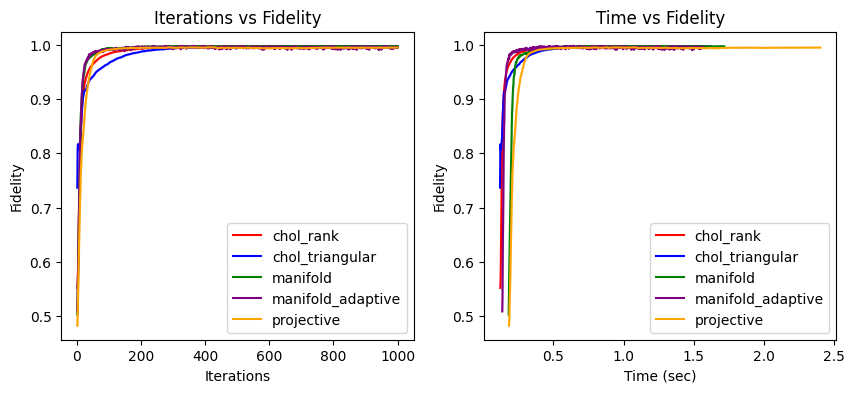

In [60]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))


###-------------Fidelity Vs iterations -------------#######

ax1.set_title("Iterations vs Fidelity", fontsize=12)

iterations = np.arange(1,len(f_gd_chol_rank)+1)   # total number of iterations

ax1.plot(iterations, mean_fid_chol_rank, color='red',label="chol_rank")
ax1.fill_between(iterations, mean_fid_chol_rank - std_fid_chol_rank, mean_fid_chol_rank + std_fid_chol_rank, alpha=0.2, color='red')

ax1.plot(iterations, mean_fid_chol_triangular, color='blue',label="chol_triangular")
ax1.fill_between(iterations, mean_fid_chol_triangular - std_fid_chol_triangular, mean_fid_chol_triangular + std_fid_chol_triangular, alpha=0.2, color='blue')

ax1.plot(iterations, mean_fid_mani, color='green',label="manifold")
ax1.fill_between(iterations, mean_fid_mani - std_fid_mani, mean_fid_mani + std_fid_mani, alpha=0.2, color='green')

ax1.plot(iterations, mean_fid_mani_adaptive, color='purple',label="manifold_adaptive")
ax1.fill_between(iterations, mean_fid_mani_adaptive - std_fid_mani_adaptive, mean_fid_mani_adaptive + std_fid_mani_adaptive, alpha=0.2, color='purple')

ax1.plot(iterations, mean_fid_proj, color='orange',label="projective")
ax1.fill_between(iterations, mean_fid_proj - std_fid_proj, mean_fid_proj + std_fid_proj, alpha=0.2, color='orange')

ax1.legend(loc='lower right')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Fidelity")


###-------------Fidelity Vs time -------------#######

ax2.set_title("Time vs Fidelity", fontsize=12)

ax2.plot(mean_time_chol_rank, mean_fid_chol_rank, color='red',label="chol_rank")
ax2.fill_between(mean_time_chol_rank, mean_fid_chol_rank - std_fid_chol_rank, mean_fid_chol_rank + std_fid_chol_rank, alpha=0.2, color='red')

ax2.plot(mean_time_chol_triangular, mean_fid_chol_triangular, color='blue',label="chol_triangular")
ax2.fill_between(mean_time_chol_triangular, mean_fid_chol_triangular - std_fid_chol_triangular, mean_fid_chol_triangular + std_fid_chol_triangular, alpha=0.2, color='blue')

ax2.plot(mean_time_mani, mean_fid_mani, color='green',label="manifold")
ax2.fill_between(mean_time_mani, mean_fid_mani - std_fid_mani, mean_fid_mani + std_fid_mani, alpha=0.2, color='green')

ax2.plot(mean_time_mani_adaptive, mean_fid_mani_adaptive, color='purple',label="manifold_adaptive")
ax2.fill_between(mean_time_mani_adaptive, mean_fid_mani_adaptive - std_fid_mani_adaptive, mean_fid_mani_adaptive + std_fid_mani_adaptive, alpha=0.2, color='purple')

ax2.plot(mean_time_proj, mean_fid_proj, color='orange',label="projective")
ax2.fill_between(mean_time_proj, mean_fid_proj - std_fid_proj, mean_fid_proj + std_fid_proj, alpha=0.2, color='orange')


ax2.legend(loc='lower right')
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Fidelity")

plt.show()


In [19]:
print('max fidelity (chol_rank) and time in seconds :', [np.max(f_gd_chol_rank), mean_time_chol_rank[np.argmax(mean_fid_chol_rank)]])
print('max fidelity (chol_triangular):', [np.max(f_gd_chol_triangular), mean_time_chol_triangular[np.argmax(mean_fid_chol_triangular)]])
print('max fidelity (chol_manifold):', [np.max(f_gd_mani), mean_time_mani[np.argmax(mean_fid_mani)]])
print('max fidelity (chol_manifold_adaptive):', [np.max(f_gd_mani_adaptive), mean_time_mani_adaptive[np.argmax(mean_fid_mani_adaptive)]])
print('max fidelity (chol_proj):', [np.max(f_gd_proj), mean_time_proj[np.argmax(mean_fid_proj)]])


max fidelity (chol_rank) and time in seconds : [0.9984589789769645, 0.3752265453338623]
max fidelity (chol_triangular): [0.9236305609078864, 0.35901997089385984]
max fidelity (chol_manifold): [0.998243519089992, 1.219911766052246]
max fidelity (chol_manifold_adaptive): [0.9970892628505614, 1.0888127088546753]
max fidelity (chol_proj): [0.998965918828908, 3.2906385898590087]


## GHZ state
Now let's reconstruct a GHZ state
$$ \frac{|000\rangle + |111\rangle}{\sqrt{2}}$$

In [20]:
# Define the basis states |0> and |1> for a single qubit
zero = qtp.basis(2, 0)  # |0>
one = qtp.basis(2, 1)   # |1>

# Construct the |000> and |111> states for 3 qubits
state_000 = qtp.tensor(zero, zero, zero)  # |000>
state_111 = qtp.tensor(one, one, one)     # |111>

# Create the GHZ state: (|000> + |111>) / sqrt(2)
ghz_state = (state_000 + state_111).unit()
ghz_state = qtp.Qobj(ghz_state.full(), dims=[[8], [1]])  # Reshape the GHZ state to have dimensions [8]
# This reshape is necessary for the function qtp.expect. It will depend of the version of QuTip
 
print(ghz_state)

Quantum object: dims=[[8], [1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]]


In [21]:
# List to save the values of fidelity and time for the GD methods

fid_list_chol_rank, fid_list_chol_triangular, fid_list_mani, fid_list_mani_adaptive, fid_list_proj = [], [], [], [], []
time_list_chol_rank, time_list_chol_triangular, time_list_mani, time_list_mani_adaptive, time_list_proj = [], [], [], [], []


max_itera: int = 100
batch_s = round(0.5*len(ops_jnp)) # The batch size, taking a group of measurement operators 

# The for is to run all the methods multiple times, and then have an average 
for i in range(10):  

    # measuring the 
    rho_or = ghz_state
    data = qtp.expect(Measu_ope,rho_or)

    ##-----------------GD-QST starts ---------------
    # define rank of ansatz
    rank = 1 # maximum rank is 2**N
    T_rank, T_triangular, column_ket_pro, ket_f, prob1_array_jnp = ansatz(rank)

    # ..........................................................................
    # GD-QST-Cholesky-Rank 
    
    rho_gd_chol_rank, f_gd_chol_rank, t_gd_chol_rank, _ = gd_chol_rank(data, rho_or, ops_jnp, T_rank, max_itera, batch_s, 
                                                            lr=0.5, decay= 0.999,lamb=0, tqdm_off=False)
    fid_list_chol_rank.append(f_gd_chol_rank)
    time_list_chol_rank.append(t_gd_chol_rank)

    #...........................................................................
    # GD-QST-Cholesky-triangular
    rho_gd_chol_triangular, f_gd_chol_triangular, t_gd_chol_triangular, _ = gd_chol_triangular(data, rho_or, ops_jnp, T_triangular, max_itera, batch_s, 
                                                            lr=0.5, decay= 0.999,lamb=0, tqdm_off=False)
    fid_list_chol_triangular.append(f_gd_chol_triangular)
    time_list_chol_triangular.append(t_gd_chol_triangular)

    # ...........................................................................
    # GD-QST-manifold
    rho_gd_mani, f_gd_mani, t_gd_mani, loss_gd_mani = gd_manifold(data, rho_or, ops_jnp, column_ket_pro, max_itera, batch_s, 
                                                           lr=0.1, decay=0.997, lamb=0, tqdm_off=False)   
    fid_list_mani.append(f_gd_mani)
    time_list_mani.append(t_gd_mani)
             
    # ...........................................................................                                  
    # GD-QST-manifold-adaptive
    rho_gd_mani_adaptive, f_gd_mani_adaptive, t_gd_mani_adaptive, _ = gd_manifold_adaptive(data, rho_or, ops_jnp, column_ket_pro, max_itera, batch_s, 
                                                            lr=1e-1, boost = 1.08, decay = 0.99, lamb = 0, tqdm_off=False)
    fid_list_mani_adaptive.append(f_gd_mani_adaptive)
    time_list_mani_adaptive.append(t_gd_mani_adaptive)
    
    # ...........................................................................
    # GD-QST-projection
    rho_gd_proj, f_gd_proj, t_gd_proj, loss_gd_proj = gd_project(data, rho_or, ops_jnp, ket_f, prob1_array_jnp, max_itera, batch_s,
                                                             lr=1e-1, decay=0.099, lamb=0, tqdm_off=False)
    fid_list_proj.append(f_gd_proj)
    time_list_proj.append(t_gd_proj)

ValueError: incompatible dimensions [16] and [8]

In [10]:
fid_list_chol_rank = np.array(fid_list_chol_rank)
fid_list_chol_triangular = np.array(fid_list_chol_triangular)
fid_list_mani = np.array(fid_list_mani)
fid_list_mani_adaptive = np.array(fid_list_mani_adaptive)
fid_list_proj = np.array(fid_list_proj)


# Compute mean fidelity
mean_fid_chol_rank = np.mean(fid_list_chol_rank, axis=0)
mean_fid_chol_triangular = np.mean(fid_list_chol_triangular, axis=0)
mean_fid_mani = np.mean(fid_list_mani, axis=0)
mean_fid_mani_adaptive = np.mean(fid_list_mani_adaptive, axis=0)
mean_fid_proj = np.mean(fid_list_proj, axis=0)

# Compute standard deviation in the mean fidelity
std_fid_chol_rank = np.std(fid_list_chol_rank, axis=0)
std_fid_chol_triangular = np.std(fid_list_chol_triangular, axis=0)
std_fid_mani = np.std(fid_list_mani, axis=0)
std_fid_mani_adaptive = np.std(fid_list_mani_adaptive, axis=0)
std_fid_proj = np.std(fid_list_proj, axis=0)


########################### Average time ###################

time_list_chol_rank = np.array(time_list_chol_rank)
time_list_chol_triangular = np.array(time_list_chol_triangular)
time_list_mani = np.array(time_list_mani)
time_list_mani_adaptive = np.array(time_list_mani_adaptive)
time_list_proj = np.array(time_list_proj)

# Compute mean fidelity
mean_time_chol_rank = np.mean(time_list_chol_rank, axis=0)
mean_time_chol_triangular = np.mean(time_list_chol_triangular, axis=0)
mean_time_mani = np.mean(time_list_mani, axis=0)
mean_time_mani_adaptive = np.mean(time_list_mani_adaptive, axis=0)
mean_time_proj = np.mean(time_list_proj, axis=0)

# Compute standard deviation in the mean fidelity
std_time_chol_rank = np.std(time_list_chol_rank, axis=0)
std_time_chol_triangular = np.std(time_list_chol_triangular, axis=0)
std_time_mani = np.std(time_list_mani, axis=0)
std_time_mani_adaptive = np.std(time_list_mani_adaptive, axis=0)
std_time_proj = np.std(time_list_proj, axis=0)

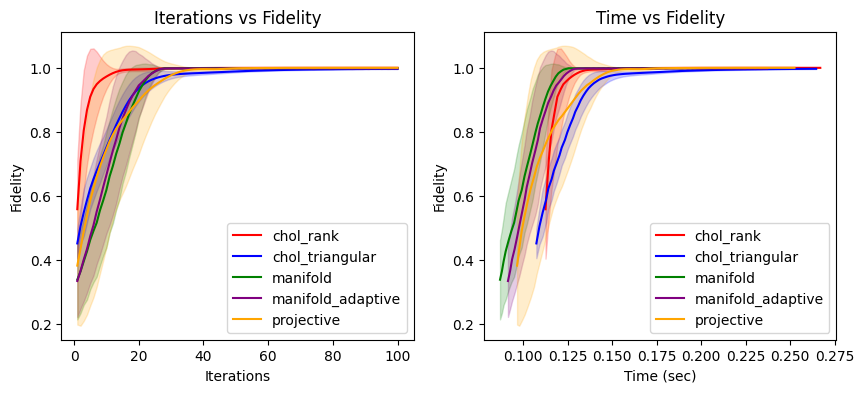

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))


###-------------Fidelity Vs iterations -------------#######

ax1.set_title("Iterations vs Fidelity", fontsize=12)

iterations = np.arange(1,len(f_gd_chol_rank)+1)   # total number of iterations

ax1.plot(iterations, mean_fid_chol_rank, color='red',label="chol_rank")
ax1.fill_between(iterations, mean_fid_chol_rank - std_fid_chol_rank, mean_fid_chol_rank + std_fid_chol_rank, alpha=0.2, color='red')

ax1.plot(iterations, mean_fid_chol_triangular, color='blue',label="chol_triangular")
ax1.fill_between(iterations, mean_fid_chol_triangular - std_fid_chol_triangular, mean_fid_chol_triangular + std_fid_chol_triangular, alpha=0.2, color='blue')

ax1.plot(iterations, mean_fid_mani, color='green',label="manifold")
ax1.fill_between(iterations, mean_fid_mani - std_fid_mani, mean_fid_mani + std_fid_mani, alpha=0.2, color='green')

ax1.plot(iterations, mean_fid_mani_adaptive, color='purple',label="manifold_adaptive")
ax1.fill_between(iterations, mean_fid_mani_adaptive - std_fid_mani_adaptive, mean_fid_mani_adaptive + std_fid_mani_adaptive, alpha=0.2, color='purple')

ax1.plot(iterations, mean_fid_proj, color='orange',label="projective")
ax1.fill_between(iterations, mean_fid_proj - std_fid_proj, mean_fid_proj + std_fid_proj, alpha=0.2, color='orange')

ax1.legend(loc='lower right')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Fidelity")


###-------------Fidelity Vs time -------------#######

ax2.set_title("Time vs Fidelity", fontsize=12)

ax2.plot(mean_time_chol_rank, mean_fid_chol_rank, color='red',label="chol_rank")
ax2.fill_between(mean_time_chol_rank, mean_fid_chol_rank - std_fid_chol_rank, mean_fid_chol_rank + std_fid_chol_rank, alpha=0.2, color='red')

ax2.plot(mean_time_chol_triangular, mean_fid_chol_triangular, color='blue',label="chol_triangular")
ax2.fill_between(mean_time_chol_triangular, mean_fid_chol_triangular - std_fid_chol_triangular, mean_fid_chol_triangular + std_fid_chol_triangular, alpha=0.2, color='blue')

ax2.plot(mean_time_mani, mean_fid_mani, color='green',label="manifold")
ax2.fill_between(mean_time_mani, mean_fid_mani - std_fid_mani, mean_fid_mani + std_fid_mani, alpha=0.2, color='green')

ax2.plot(mean_time_mani_adaptive, mean_fid_mani_adaptive, color='purple',label="manifold_adaptive")
ax2.fill_between(mean_time_mani_adaptive, mean_fid_mani_adaptive - std_fid_mani_adaptive, mean_fid_mani_adaptive + std_fid_mani_adaptive, alpha=0.2, color='purple')

ax2.plot(mean_time_proj, mean_fid_proj, color='orange',label="projective")
ax2.fill_between(mean_time_proj, mean_fid_proj - std_fid_proj, mean_fid_proj + std_fid_proj, alpha=0.2, color='orange')


ax2.legend(loc='lower right')
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Fidelity")

plt.show()


In [12]:
print('max fidelity (chol_rank) and time in seconds :', [np.max(f_gd_chol_rank), mean_time_chol_rank[np.argmax(mean_fid_chol_rank)]])
print('max fidelity (chol_triangular):', [np.max(f_gd_chol_triangular), mean_time_chol_triangular[np.argmax(mean_fid_chol_triangular)]])
print('max fidelity (chol_manifold):', [np.max(f_gd_mani), mean_time_mani[np.argmax(mean_fid_mani)]])
print('max fidelity (chol_manifold_adaptive):', [np.max(f_gd_mani_adaptive), mean_time_mani_adaptive[np.argmax(mean_fid_mani_adaptive)]])
print('max fidelity (chol_proj):', [np.max(f_gd_proj), mean_time_proj[np.argmax(mean_fid_proj)]])


max fidelity (chol_rank) and time in seconds : [0.9999991455832821, 0.2668310642242432]
max fidelity (chol_triangular): [0.9967457911687542, 0.2645196676254272]
max fidelity (chol_manifold): [0.9999276382595813, 0.2136611223220825]
max fidelity (chol_manifold_adaptive): [0.9999520851977658, 0.22889189720153807]
max fidelity (chol_proj): [0.9999938398259918, 0.2523620843887329]
